# Bucket Pricing

The main idea is to clean the distributions of the categories included in the data (each CategoryDesc and Manufacturer will be considered as a different category), to create groups of similar categories using the **Kolmogorov-Smirnoff test**.

Then, having groups of similar categories, create buckets for the ones that has not too much variance.

The data will have filters, given by Michael Keim's team

- Sales from June 2020 and forward
- Min sold price of $50
- Exclude 271+
- All item conditions
- LTV filter >= 20% and <=80%
- 30 or more transactions (we will need evaluate further based on the addition of all item conditions) 
- Exclude items discounted by 25% or more (Total Discount)
- Exclude manufacturers that are beneath 80% of the category composition
- In an effort to remove erroneous manufacturer names/bad data
- Don’t group categories
- Categories that use attributes can we use the KS method to find similarities in distributions - and if they can be grouped?
- Use IQR Fences
- 30 or more transactions that meet the above criteria

#  Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(forcats)
library(readr)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Read Data

In [2]:
data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_MX.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  original_price = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  Item_ezid = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  store = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.

Warning message:
“27669 parsing failures.
 row            col expected actual                                                                     file
1089 original_price a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_MX.csv'
1090 original_price a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_MX.csv'
1213 original_price a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_MX.csv'
1250 original_price a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/buc

In [3]:
data$date <- substr(data$origindate,1,10) %>% as.Date

Example of 1 row of the data

In [4]:
head(data,1) %>% t

[,1]                     
Country             MEX                      
primary_relation    432232786                
gid                 38682292                 
origindate          2020-10-23 15:50:36 +0000
FiscalYear          2021                     
original_price      649                      
sold_price          100                      
tax                 13.79                    
Item_ezid           852310136666             
ItemID              514800194                
cost                250                      
item_categorization 573002                   
Primary             General Merchandise      
Secondary           Household/Office Goods   
Tertiary            Telephone                
CategoryDesc        Cellular Telephone       
item_type           GM                       
store               85231                    
transType           Sales                    
customerType        Customer                 
Inventory_Days      252                      
Manufacturer        SENWA                    
Model_Number        JAZZ S471                
item_cond           B                        
date                2020-10-23

Manufacturer in lowercase, without spaces

In [5]:
data %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Manufacturer = gsub(' ', '', Manufacturer)) -> data

In [6]:
f0 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

# Cleaning  Data

## Drop big categories

The business wants buckets for "other stuff", so it will be dropped categories like:
 - TVs
 - Videogames
 - Tablets
 - Cellphones
 - Laptop

In [8]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'null',
'Shoes',
'NULL')

In [9]:
data %>%
 filter(!(CategoryDesc %in% x)) -> data

Drop Manufacturer in NULL

In [10]:
data %>%
 filter(Manufacturer != 'null', !is.na(Manufacturer),
        CategoryDesc != 'null', !is.na(CategoryDesc)) -> data

In [11]:
f1 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## July 2020 and forward

In [12]:
data %>%
 filter(date >= as.Date('2020-07-01')) -> data

In [13]:
f2 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Sold price > 50 MXN

For the business, every item sold <= 50 MXN has no importance, so will be filtered

In [14]:
data %>%
 filter(sold_price >= 50) -> data

In [15]:
f3 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Sold in first 271 days

In [16]:
data %>%
 filter(Inventory_Days <= 271) -> data

In [17]:
f4 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## LTV filter

Just items with LTV between 20% and 80%

In [18]:
data %>%
 mutate(LTV = cost/sold_price) %>%
 filter(LTV >= 0.2, LTV <= 0.8) -> data


In [19]:
f5 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Create Category

Paste the Manufacturer and the CategoryDesc to create the Categories

In [20]:
data %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data

## 30 items

To have reasonable distributions, only will be considered CategoryDesc with at least 30 items

In [21]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(n = n()) %>%
 filter(n >= 30) %>%
 select(-n) -> data

In [22]:
f6 <- c(nrow(data),length(unique(data$CategoryDesc)))

## Discount < 25%

In [23]:
options(warn=-1)
data %>%
 mutate(dct = 1 - (as.numeric(sold_price)/as.numeric(original_price))) %>%
 filter(dct < 0.25, !is.na(dct))  %>%
 select(-dct) -> data

In [24]:
f7 <- c(nrow(data),length(unique(data$CategoryDesc)))

## 80% of Manufacturers by CategoryDesc

In [24]:
#data %>%
# filter(Manufacturer != 'null') %>%
# group_by(CategoryDesc_original,Manufacturer) %>%
# tally %>%
# ungroup %>%
# group_by(CategoryDesc_original) %>%
# mutate(total = sum(n)) %>%
# ungroup %>%
# mutate(pct = n/total) %>%
# group_by(CategoryDesc_original) %>%
# arrange(desc(pct)) %>%
# group_by(CategoryDesc_original) %>%
# mutate(cum_sum = cumsum(pct)) %>%
# filter(cum_sum <= 0.8) %>%
# ungroup %>%
# mutate(CategoryDesc = paste0(Manufacturer,'-',CategoryDesc_original)) %>%
# select(CategoryDesc) %>%
# pull %>%
# unique -> above80

In [25]:
#data %>%
# filter(CategoryDesc %in% above80) -> data


In [26]:
#f8 <- c(nrow(data),length(unique(data$CategoryDesc)))


## Drop outliers

Left and right outliers will be dropped, using the boxplot filters

In [25]:
LimInf_fun <- function(x){
    a <- boxplot(x, plot = FALSE)
    
    b <- a$stats[1]
    
    return(b)
}

In [26]:
LimSup_fun <- function(x){
    a <- boxplot(x, plot = FALSE)
    
    b <- a$stats[5]
    
    return(b)
}

In [28]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(lim_inf = LimInf_fun(sold_price),
        lim_sup = LimSup_fun(sold_price)) %>%
 ungroup %>%
 filter(sold_price > lim_inf, sold_price < lim_sup) %>%
 select(-lim_inf, -lim_sup) -> data

In [29]:
f9 <- c(nrow(data),length(unique(data$CategoryDesc)))

# Waterfall

Plot with the number of rows and unique CategoryDesc and Manufacturer

In [30]:
data.frame(rbind(f0,f1,f2,f3,f4,f5,f6,f7,#f8,
                 f9)) -> wf

names(wf) <- c('Rows','Distinct_CatMan')

desc <- c('No Filter',
          'Drop big categories',
          '>= July 2020',
          'Sold Price >= $5',
          'Sold first 271 days',
          'LTV filter',
          '30 transactions',
          'Discount <= 25%',
          #'80% Manufactures Dist',
          'Boxplot Outliers')

wf$desc <- desc
wf$desc <- fct_inorder(wf$desc)

## Total rows

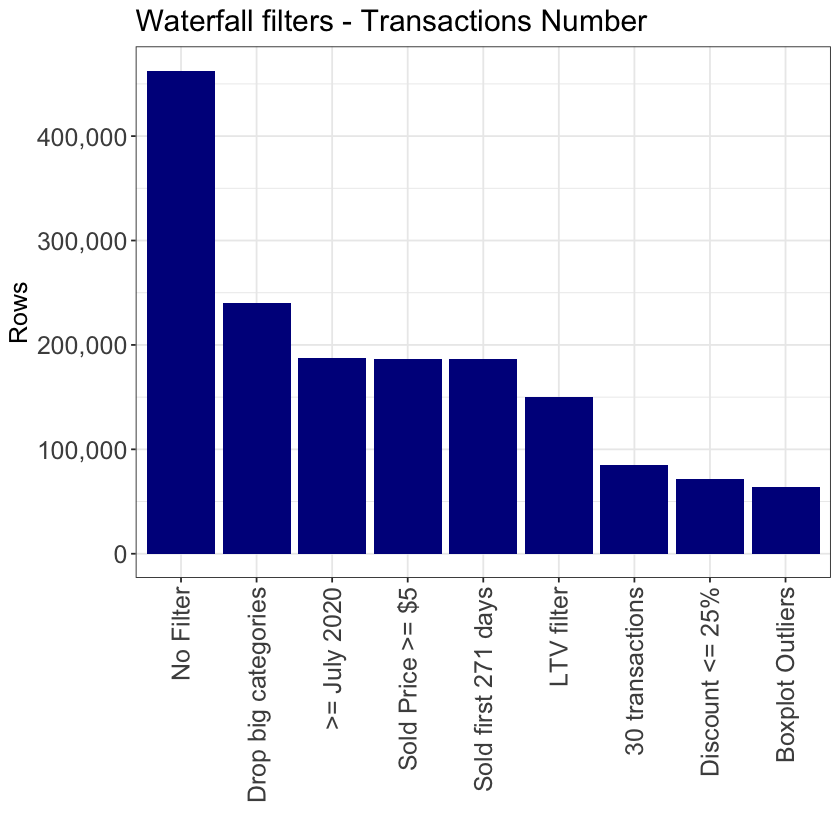

In [31]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Rows), fill = 'darkblue') +
 ggtitle('Waterfall filters - Transactions Number') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma)

## Unique Manufacturer-CategoryDesc

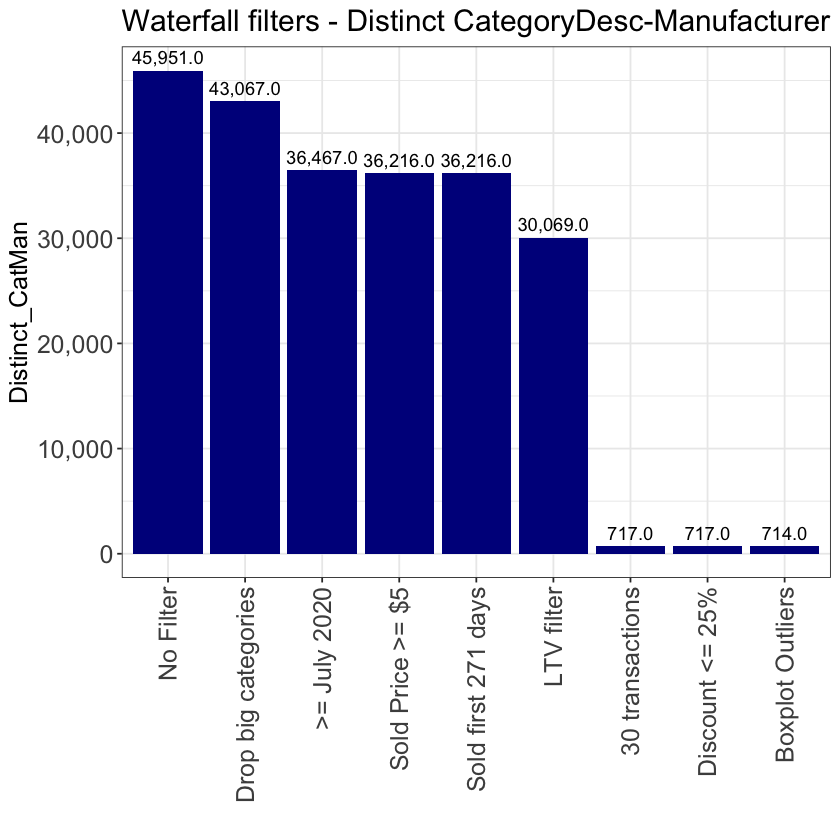

In [32]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Distinct_CatMan), fill = 'darkblue') +
 ggtitle('Waterfall filters - Distinct CategoryDesc-Manufacturer') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma) +
 geom_text(aes(x     = desc,
               y     = Distinct_CatMan, 
               label = scales::comma(Distinct_CatMan)), vjust = -0.5)

# KS Test

Calculate the **Kolmogorov-Smirnoff p-value** for each combination of CategoryDesc

Create a data frame with all possible combinations of Category Desc

In [33]:
cd <- unique(data$CategoryDesc)

In [34]:
expand.grid.unique <- function(x, y, include.equals=FALSE)
{
    x <- unique(x)

    y <- unique(y)

    g <- function(i)
    {
        z <- setdiff(y, x[seq_len(i-include.equals)])

        if(length(z)) cbind(x[i], z, deparse.level=0)
    }

    do.call(rbind, lapply(seq_along(x), g))
}

In [35]:
expand.grid.unique(cd,cd) %>%
 as.data.frame %>%
 mutate(V1 = as.character(V1),
        V2 = as.character(V2)) -> comb

In [36]:
comb$ks <- NA

In [37]:
nrow(comb)

[1] 254541

In [38]:
options(warn=-1)
for(i in 1:nrow(comb)){
    cat1 <- comb$V1[i]
    cat2 <- comb$V2[i]
    
    data %>%
     filter(CategoryDesc == cat1) %>%
     select(sold_price) %>%
     pull -> d1
    
    data %>%
     filter(CategoryDesc == cat2) %>%
     select(sold_price) %>%
     pull -> d2
    
    ks <- ks.test(d1,d2)
    
    comb$ks[i] <- ks$p.value
    
    
    # Print iterations to see the advance of the for loop
    g <- seq(100000,800000,by = 100000)
    if(i %in% g){print(i)}
    
    
}

[1] 100000
[1] 200000


In [40]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/MX/')


In [41]:
write.csv(comb,file = 'CategoryDesc_ManufacturerKS_TimFilter_MX.csv',row.names = FALSE)


In [42]:
#comb <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/MX/CategoryDesc_ManufacturerKS_TimFilter_MX.csv')

## Example of similar distributions

In [43]:
comb %>% filter(ks >= 0.05) %>% filter(grepl('dewalt-Cordless Drill',V1)) %>% head


V1                    V2                                     ks        
1 dewalt-Cordless Drill singer-Sewing Machine                  0.50525767
2 dewalt-Cordless Drill miroir-Digital Video Projector         0.59935282
3 dewalt-Cordless Drill ridgid-Cordless Combo Drills / Drivers 0.05570839
4 dewalt-Cordless Drill remington-Pole Saw                     0.16302891
5 dewalt-Cordless Drill bosch-Cordless Impact Drills           0.24173525
6 dewalt-Cordless Drill bauer-Cordless Impact Drills           0.12866055

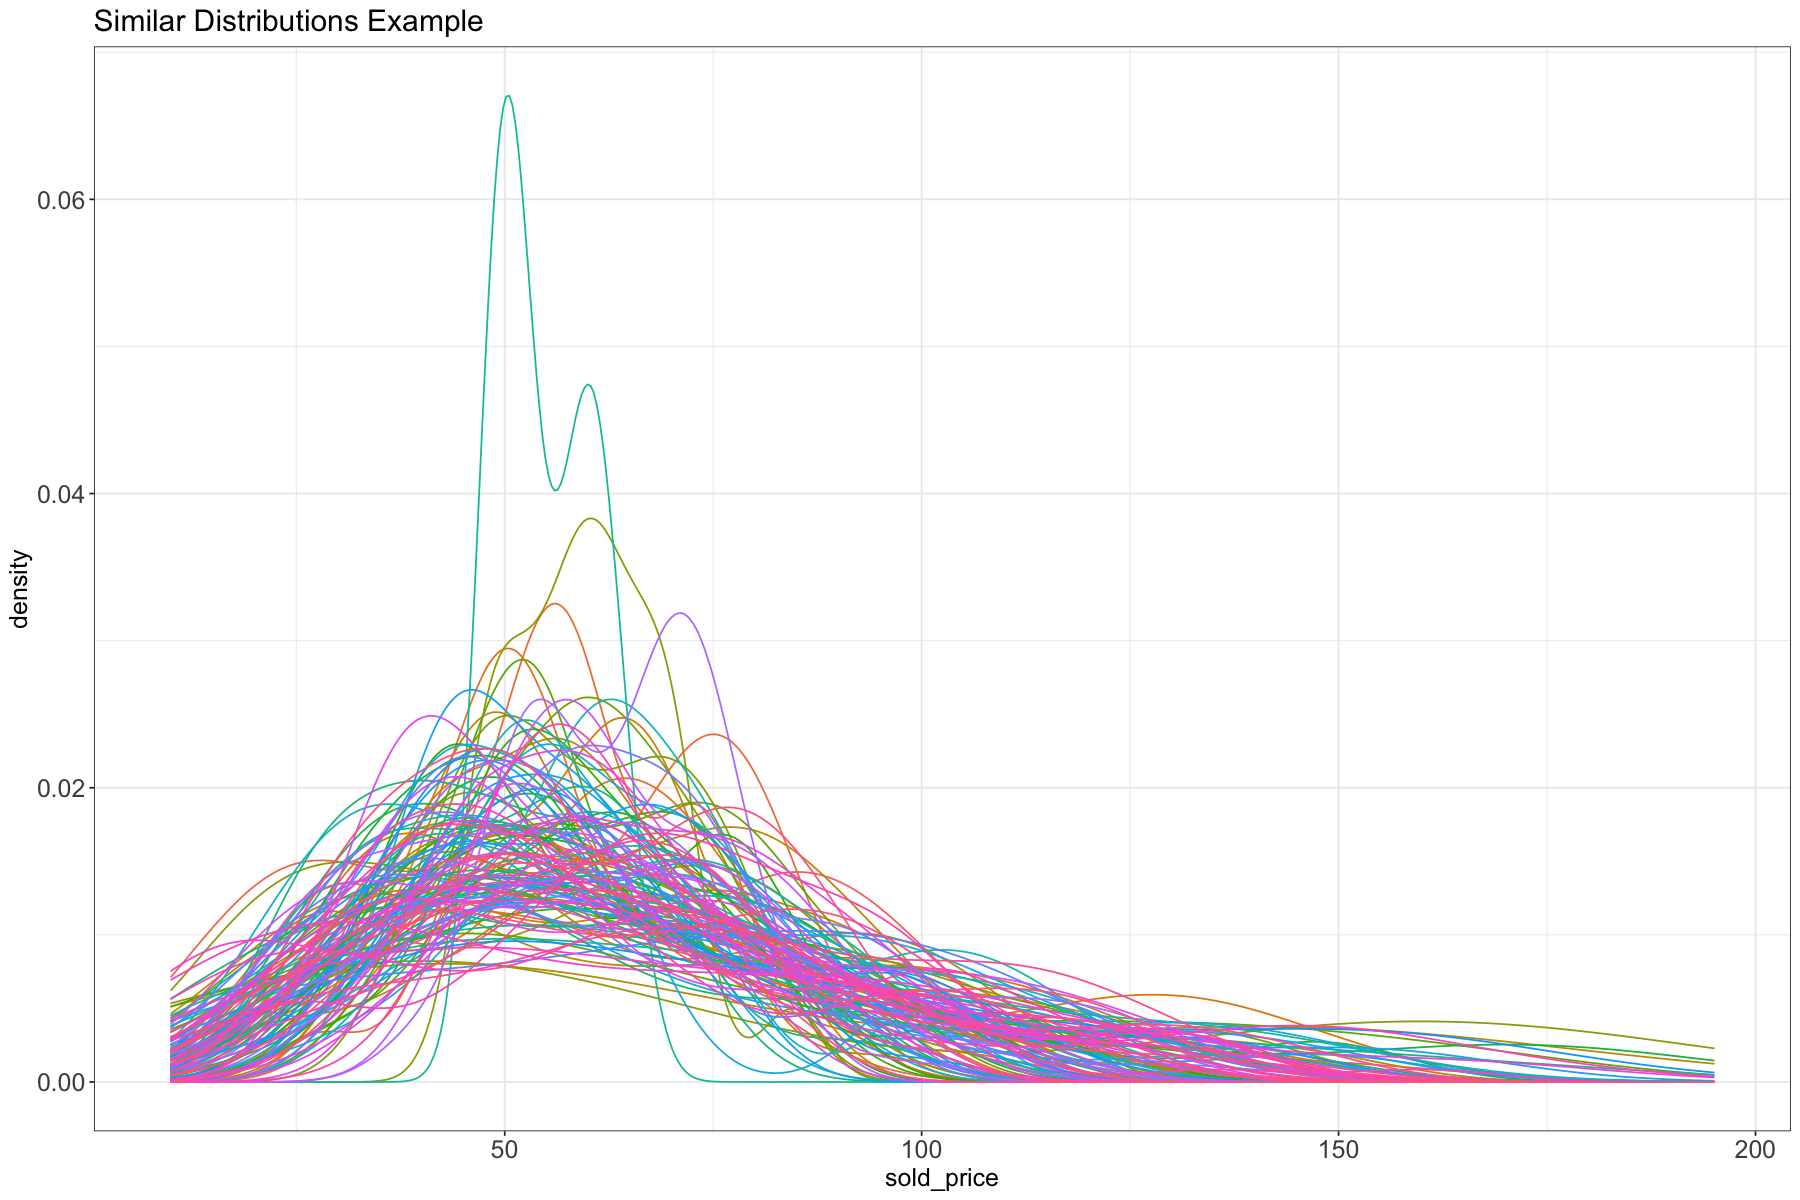

In [44]:
options(repr.plot.width=15, repr.plot.height=10)

a <- c('Cordless Drill',comb %>%
                         filter(ks >= 0.05) %>%
                         filter(grepl('dewalt-Cordless Drill',V1)) %>% select(V2) %>% pull)

data %>%
 filter(CategoryDesc %in% a) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc), alpha = 0.2) +
 theme_bw() +
 ggtitle('Similar Distributions Example') +
 theme(axis.text.x  = element_text(size = 15),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none')

## Groups

Create groups using similar distributions

In [45]:
cats <- unique(c(comb$V1,comb$V2))


In [46]:
data.frame(CategoryDesc = NA,
           Group        = NA,
           Reference    = NA)  %>%
 filter(!is.na(NA)) -> groups


In [47]:
for(i in 1:length(cats)){    
    if(i == 1){
        
        aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
        aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
        g   <- c(cats[i], aux1, aux2)
        data.frame(CategoryDesc = g,
                   Group        = 1,
                   Reference    = cats[i]) -> df_aux
        
        } else {
        
        if(!(cats[i] %in% groups$CategoryDesc)){
            
            aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
            aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
            g   <- c(cats[i], aux1, aux2)
            last_group <- max(groups$Group)
            data.frame(CategoryDesc = g,
                       Group        = 1+last_group,
                       Reference    = cats[i]) -> df_aux
            
        }

    }
    
    groups <- rbind(groups,df_aux)
}

In [49]:
groups %>%
 distinct -> groups

In [50]:
groups %>% head

CategoryDesc                           Group Reference            
1 dewalt-Cordless Drill                  1     dewalt-Cordless Drill
2 singer-Sewing Machine                  1     dewalt-Cordless Drill
3 miroir-Digital Video Projector         1     dewalt-Cordless Drill
4 ridgid-Cordless Combo Drills / Drivers 1     dewalt-Cordless Drill
5 remington-Pole Saw                     1     dewalt-Cordless Drill
6 bosch-Cordless Impact Drills           1     dewalt-Cordless Drill

## Solve Ties

Assign Categories in more than one group, to the most similar group.

This will be done calculating the average KS p-value for each CategoryDesc in more than 1 group, versus all the CategoryDesc in each group, and it will be assigned in the group with the highest p-value average

In [51]:
groups %>%
 group_by(CategoryDesc) %>%
 tally %>%
 filter(n > 1) %>%
 select(CategoryDesc) %>%
 pull -> reps

num_groups <- max(groups$Group)

In [52]:
for(i in 1:length(reps)){
    options(warn=-1)
    cat_rep <- reps[i]
    
    data.frame(cluster = NA,
               avg_ks  = NA) %>%
     filter(!is.na(cluster)) -> df
    
    for(j in 1:num_groups){
        categ     <- groups %>% filter(Group == j) %>% select(CategoryDesc) %>% pull
        num_categ <- length(categ)
        
        kss <- NA
        for(k in 1:num_categ){
            dist1 <- data %>% filter(CategoryDesc == categ[k]) %>% select(sold_price) %>% pull
            dist2 <- data %>% filter(CategoryDesc == cat_rep) %>% select(sold_price) %>% pull
            
            ks_p <- ks.test(dist1,dist2)
            
            kss <- c(kss,ks_p$p.value)
        }
        
        data.frame(cluster = j,
                   avg_ks  = mean(kss,na.rm = TRUE)) -> aux
        
        df <- rbind(df,aux)
    }
    
    
    df %>%
     arrange(desc(avg_ks)) %>%
     head(1) %>%
     select(cluster) %>%
     pull -> opt_cluster
    
    groups %>%
     filter(CategoryDesc != cat_rep) -> groups
    
    groups %>%
     filter(Group == opt_cluster) %>%
     select(Reference) %>%
     head(1) -> Ref
    
    data.frame(CategoryDesc = cat_rep,
               Group        = opt_cluster,
               Reference    = Ref) -> aux2
    
    groups <- rbind(groups, aux2) %>% arrange(Group)
    
}

In [53]:
write.csv(groups,file = 'groups_ManufacturerKS_TimFilters_MX.csv',row.names = FALSE)


Add the groups in all the data

In [54]:
data %>%
 left_join(groups, by = 'CategoryDesc') -> data


In [55]:
length(unique(groups$Group))


[1] 86

## Example similar Distributions

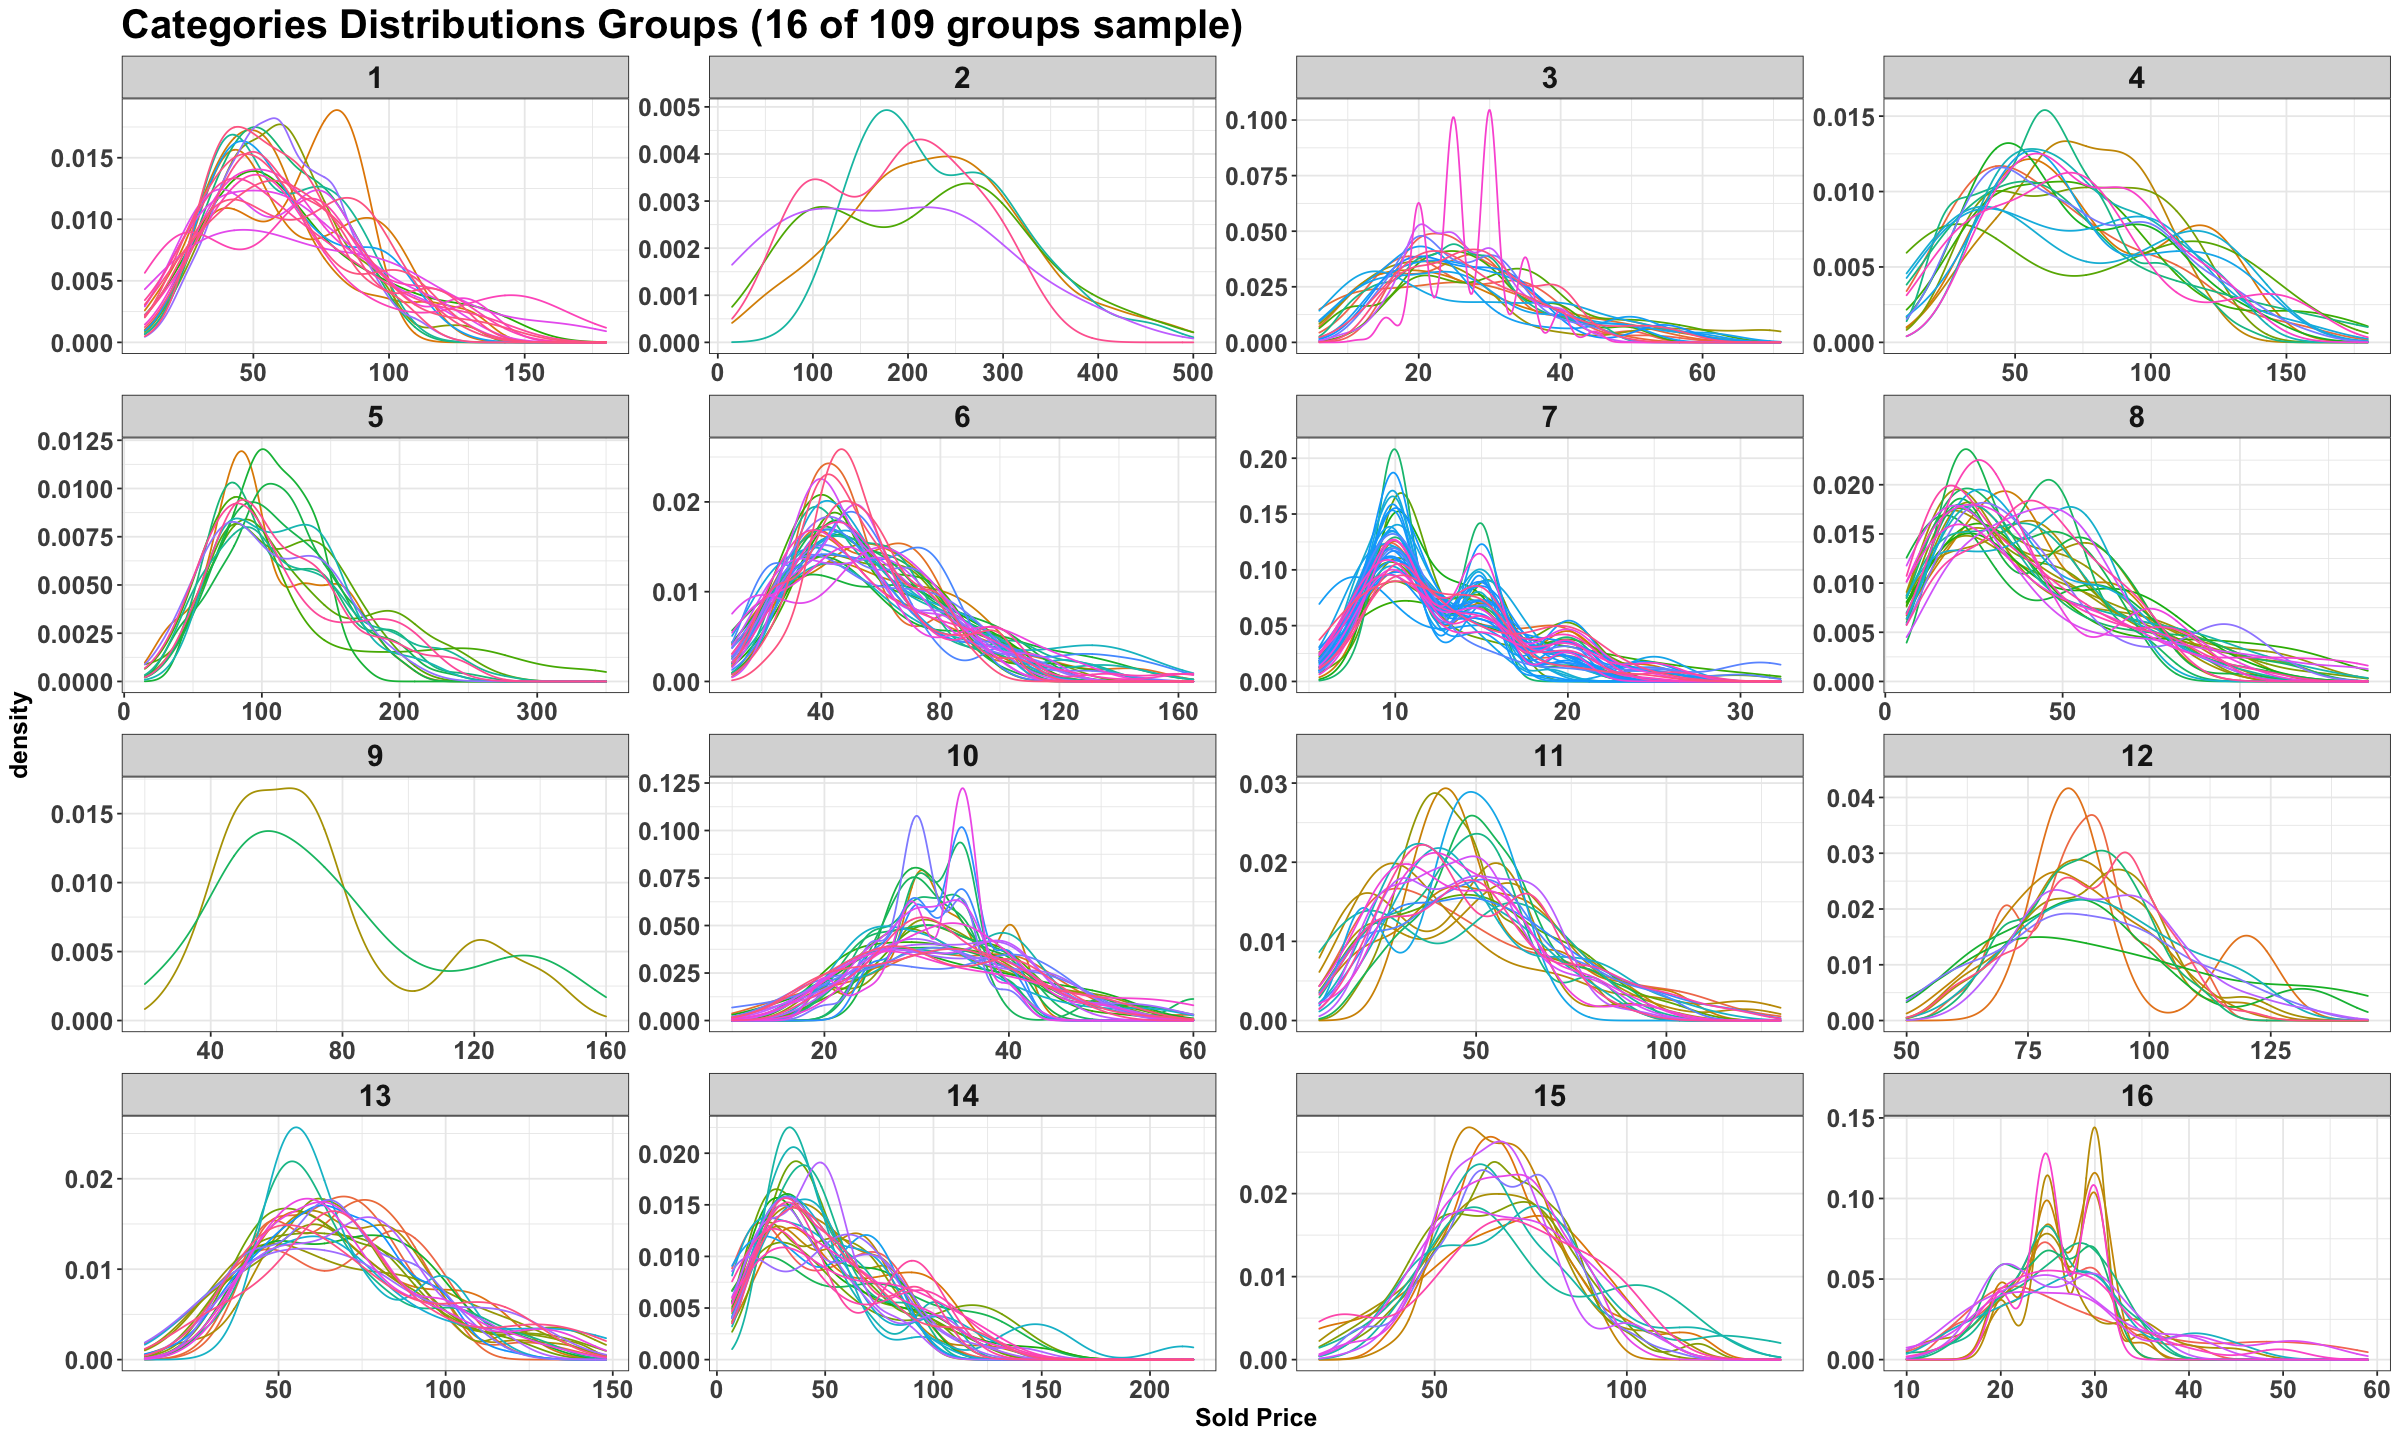

In [56]:
options(repr.plot.width=20, repr.plot.height=12)

data %>%
 filter(Group <= 16) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 facet_wrap(~Group, scales = 'free') +
 ggtitle('Categories Distributions Groups (16 of 109 groups sample)') +
 xlab('Sold Price')
 

# Write data

Write item level data, with the group

In [57]:
getwd()


[1] "/Users/darias/Documents/Bucket_Pricing/Data_Out"

In [58]:
write.csv(data %>% select(-Reference), file = 'Item_Groups_Distribution_Manufacturer_TimFilters_MX.csv', row.names = FALSE)


In [59]:
tail(groups)


CategoryDesc                  Group Reference                        
1374 hitachi-Electric Drill        86    chicagoelectric-Air Impact Wrench
1375 onn-Portable DVD Player       86    chicagoelectric-Air Impact Wrench
1376 ryobi-Corded Belt Sander      86    chicagoelectric-Air Impact Wrench
1377 ryobi-Electric Jigsaw         86    chicagoelectric-Air Impact Wrench
1378 skil-Handsaw                  86    chicagoelectric-Air Impact Wrench
1379 walmart-Counter Top Microwave 86    chicagoelectric-Air Impact Wrench

# Analysing right tail

Analyze if for the cluster 8, as an example, the right tail is because some items that really has high prices, or are employees errors

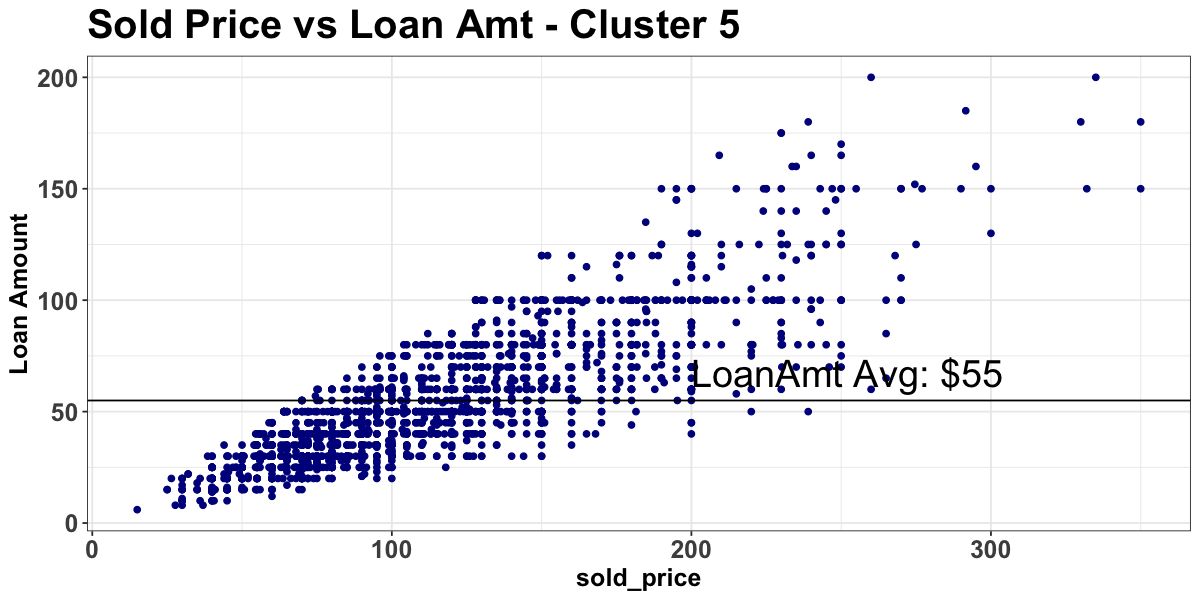

In [62]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 5) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 5) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost), colour = 'darkblue') +
 ggtitle('Sold Price vs Loan Amt - Cluster 5') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 200,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

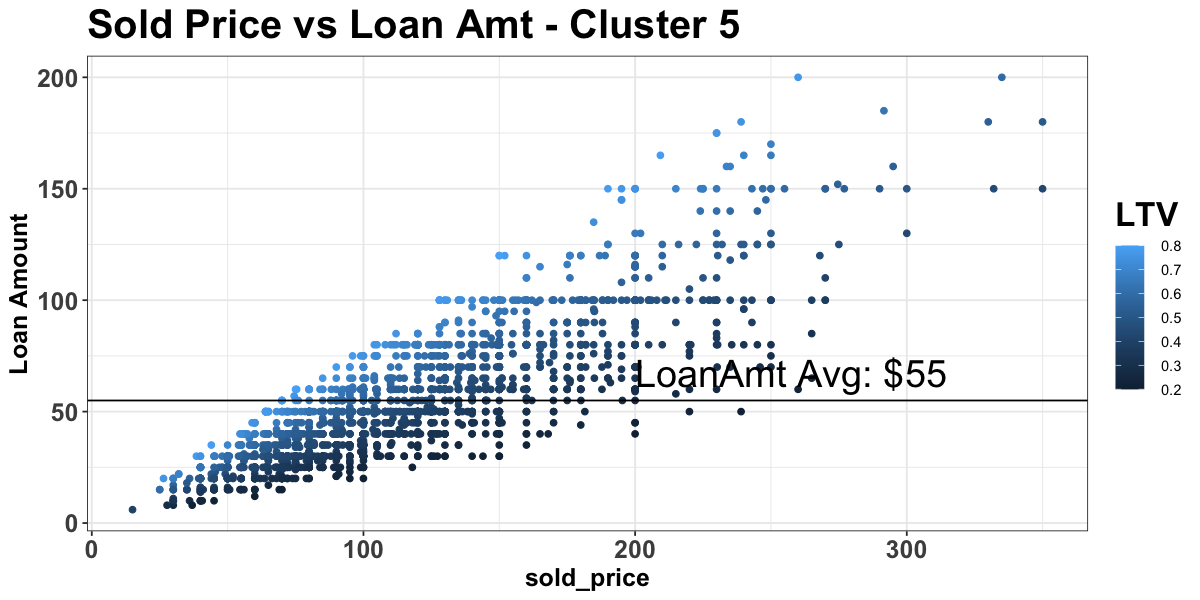

In [63]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(Group == 5) %>%
 select(cost) %>%
 pull %>%
 mean -> lam

data %>%
 filter(Group == 5) %>%
 ggplot() +
 geom_point(aes(x = sold_price, y = cost, colour = LTV)) +
 ggtitle('Sold Price vs Loan Amt - Cluster 5') +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 ylab('Loan Amount') +
 geom_hline(yintercept = lam) +
 annotate(geom  = 'text',
          x     = 200,
          y     = lam,
          label = paste0('LoanAmt Avg: $', round(lam)),
          vjust = -0.5,
          hjust = 0,
          size  = 8)

## Multimode group example

Analyze the reason of the multimode in some groups

Plot all the sold prices in the Group 9 as 1 distribution

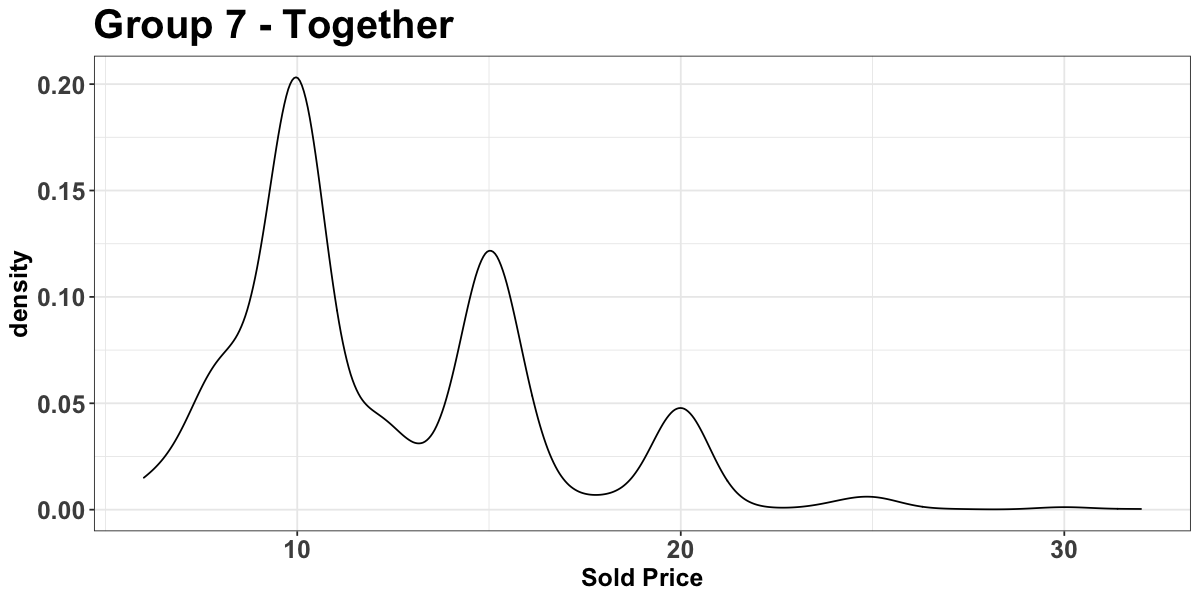

In [64]:
data %>%
 filter(Group == 7) %>%
 select(sold_price) %>%
 ggplot() +
 geom_density(aes(round(sold_price))) +
 theme_bw() +
 ggtitle('Group 7 - Together') +
 xlab('Sold Price') +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

See the modes

In [65]:
data %>%
 filter(Group == 7) %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 head(5)

sold_price n  
1 10         655
2 15         379
3  8         185
4 20         160
5 12         117

See examples of item of Group 9 with sold price in the 2 modes

In [66]:
data %>%
 filter(Group == 7, round(sold_price) %in% c(10,15)) %>%
 distinct(Manufacturer)

Manufacturer   
1  blackweb       
2  smithwesson    
3  nomfr          
4  ozarktrail     
5  soundlogic     
6  ames           
7  shenzhen       
8  ihip           
9  drillmaster    
10 pittsburgh     
11 milwaukee      
12 soleil         
13 tebco          
14 hypertough     
15 dewalt         
16 camillus       
17 newera         
18 frost          
19 samsung        
20 generalelectric
21 mtech          
22 nebo           
23 zippo

In [67]:
data %>%
 filter(Group == 7, round(sold_price) %in% c(10,15)) %>%
 mutate(Model_Number = paste0(Manufacturer,'-',Model_Number,'-',CategoryDesc_original)) %>%
 distinct(Model_Number) %>%
 head(10)

Model_Number                        
1  blackweb-PHONE CHARGER-Sim Card     
2  smithwesson-NMN-Knife               
3  nomfr-NOMN-Knife                    
4  ozarktrail-NVMN-Knife               
5  smithwesson-NMN-Sword               
6  nomfr-NVM-Battery Charger           
7  smithwesson-17-1-Sword              
8  soundlogic-2101306-Portable Speakers
9  nomfr-BT115-Stereo Headphones       
10 nomfr-NMN-Headphones & Earbuds

Manufacturers in mode and not mode

In [68]:
data %>%
 filter(Group == 7) %>%
 mutate(sold_price = round(sold_price),
        ind        = ifelse(sold_price %in% c(10,15), 'Item in mode', 'Item not in mode'),
         Model_Number = paste0(Manufacturer,'-',Model_Number,'-',CategoryDesc_original)) %>%
 group_by(ind,Model_Number) %>%
 summarise(cases = n()) %>%
 group_by(ind) %>%
 mutate(total = sum(cases),
        pct   = cases/total) %>%
 filter(pct >= 0.02)

ind              Model_Number           cases total pct       
1 Item in mode     nomfr-NMN-Booster Pack 23    1034  0.02224371
2 Item in mode     nomfr-NMN-Knife        33    1034  0.03191489
3 Item in mode     nomfr-NVMN-Knife       23    1034  0.02224371
4 Item not in mode nomfr-NMN-Booster Pack 19     780  0.02435897
5 Item not in mode nomfr-NMN-Knife        16     780  0.02051282
6 Item not in mode nomfr-NVMN-Knife       27     780  0.03461538

# Buckets

The buckets will be calculated as the **mode** of the **Group distributions**.

Not will be considered all the **Groups** for this analysis, onlye those with this characteristics:
 - Distributions with significant modes: Distributions with modes with at least 20% of the cases
  -  With kow variance/Not too flat: Groups with Skewness >= 0.5
 - Multimode: Distributions with more than 1 mode

## Calculate modes

In [69]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(Group,sold_price) %>%
 summarise(n = n()) %>%
 ungroup %>%
 group_by(Group) %>%
 mutate(total = sum(n)) %>%
 ungroup %>%
 mutate(pct = n/total) %>%
 filter(pct >= 0.2) %>%
 group_by(Group) %>%
 mutate(mode_ind = dense_rank(-pct),
        mode_ind = paste0('mode',mode_ind)) %>%
 rename('mode' = 'sold_price') %>%
 select(Group,mode,mode_ind) %>%
 group_by(Group) %>%
 mutate(num_modes = n()) %>%
 group_by(Group) %>%
 mutate(num_modes = max(num_modes)) -> modes

head(modes,4)

Group mode mode_ind num_modes
1  7    10   mode1    2        
2  7    15   mode2    2        
3 16    25   mode2    2        
4 16    30   mode1    2

## Calculate Skewness

In [70]:
skewness=function(x) {
m3=mean((x-mean(x))^3)
skew=m3/(sd(x)^3)
skew}


In [71]:
data %>%
 group_by(Group) %>%
 summarise(sk = skewness(sold_price)) -> sk_df


## Get buckets

With these rules:
 - If it is multimode, the buckets will be the modes
 - If it not multimode, and has skewness >= 0.5, and has a significant mode (>= 20%), then the bucket will be the mode

In [72]:
sk_df %>%
 left_join(modes,by='Group') %>%
 filter((num_modes==1 | sk >= 0.05) | num_modes > 1) %>%
 filter(!is.na(mode)) -> groups_buckets


Add the Manufacturer for the Groups

In [73]:
data %>%
 distinct(Group, CategoryDesc) -> CD

groups_buckets %>%
 left_join(CD,by='Group') %>%
 select(-sk) -> Manufacturer_Buckets


Write Data

In [74]:
write.csv(Manufacturer_Buckets, file = 'Buckets_Manufacturer_TimFilters_MX.csv', row.names = FALSE)

In [75]:
unique(data$CategoryDesc) %>% length


[1] 1379

In [76]:
unique(Manufacturer_Buckets$CategoryDesc) %>% length


[1] 342

In [77]:
round(547/1233,3)*100


[1] 44.4

# Examples

## No Bucket example

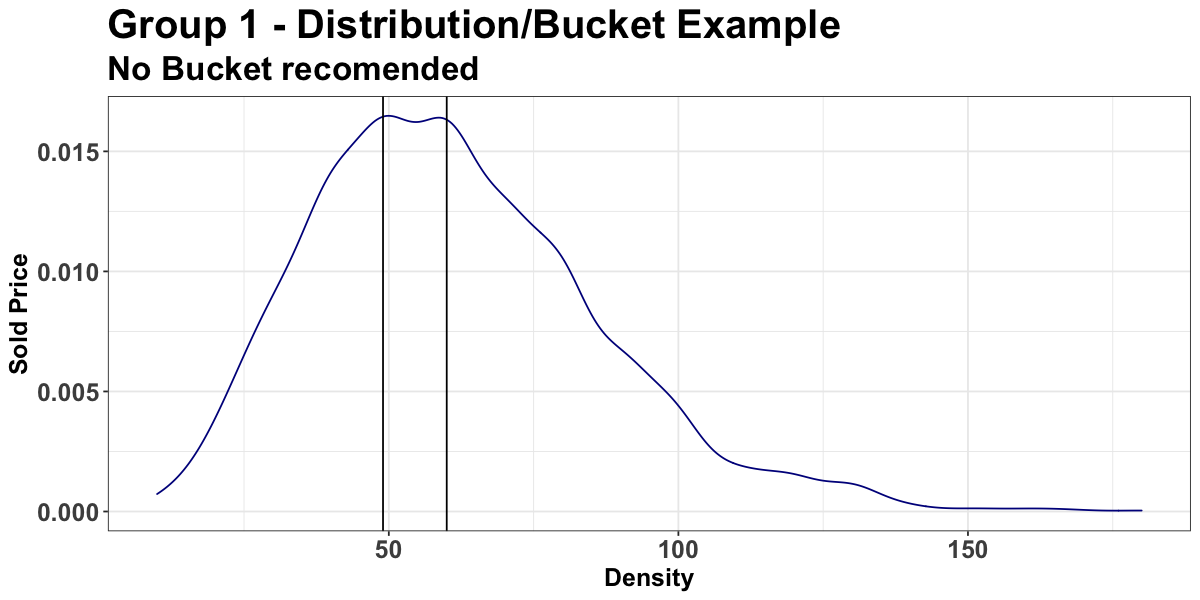

In [91]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 1) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

#a %>%
# filter(rank == 2) %>%
# select(sold_price) %>%
# pull -> m2

m2 <- 49

data %>%
 filter(Group == 1) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 1 - Distribution/Bucket Example', subtitle = 'No Bucket recomended') +
 theme_bw() +
 ylab('Sold Price') +
 xlab('Density') +
 geom_vline(xintercept = m1) +
 geom_vline(xintercept = m2) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## One Bucket Example

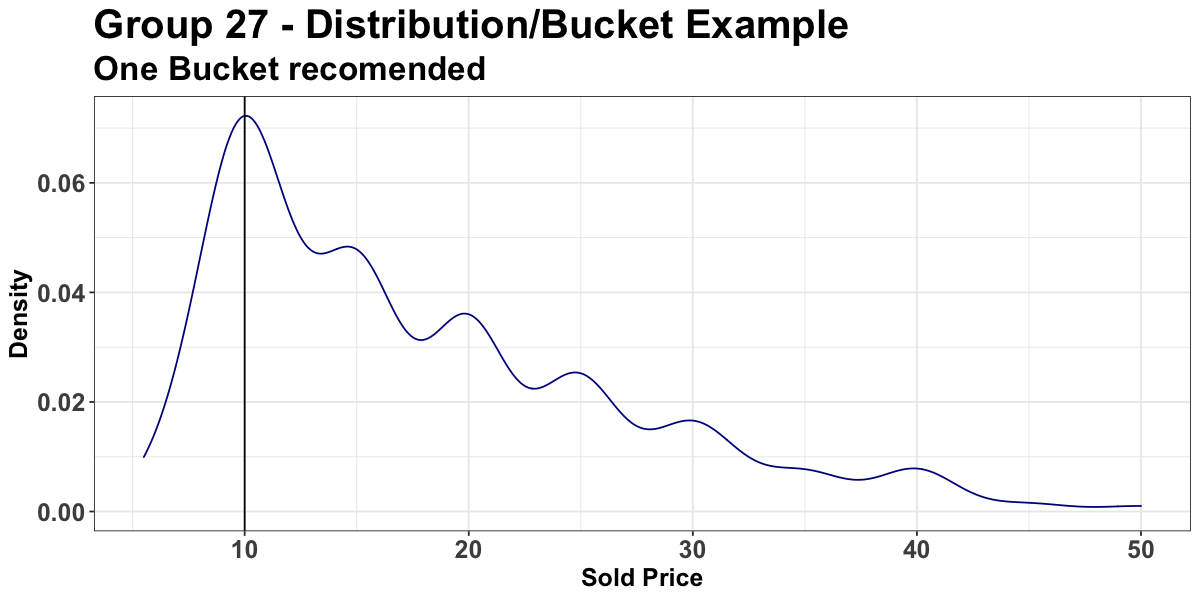

In [96]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 27) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

data %>%
 filter(Group == 27) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 27 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = m1) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

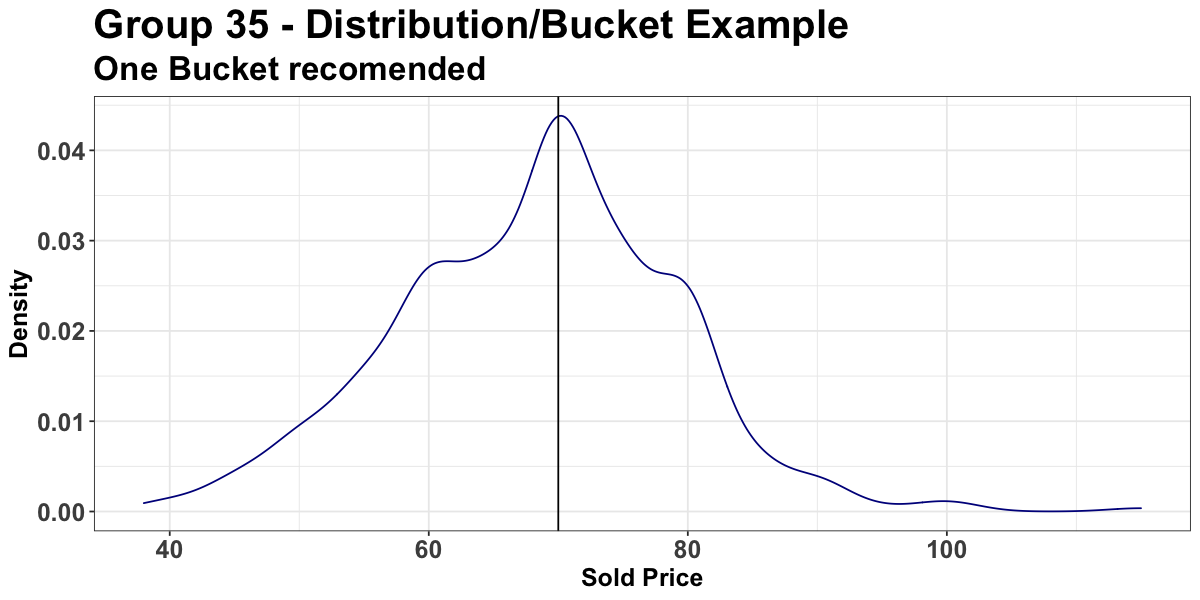

In [100]:
data %>%
 filter(Group == 35) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 35 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 70) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## Two Bucket Example

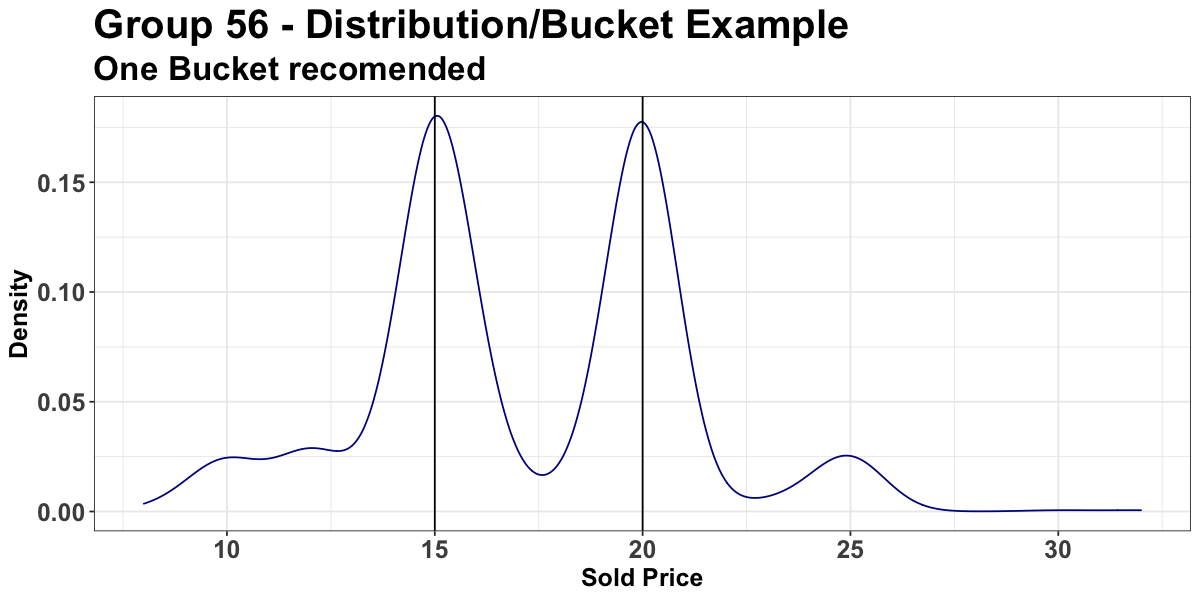

In [113]:
data %>%
 filter(Group == 56) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 56 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 15) +
 geom_vline(xintercept = 20) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Business Case

We will see the total sold amount of the Manufacturers with a bucket, using the real sold price and the one in the bucket

In [124]:
Manufacturer_Buckets %>%
 group_by(CategoryDesc) %>%
 summarise(bucket = mean(mode)) -> buc


In [125]:
data %>%
 filter(CategoryDesc %in% Manufacturer_Buckets$CategoryDesc) %>%
 left_join(buc, by = 'CategoryDesc') -> data_buc


In [130]:
real      <- sum(data_buc$sold_price)
estimated <- sum(data_buc$bucket)

print(paste0('The real amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real))))
print(paste0('The estimated amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated))))

[1] "The real amount earned for items with Manufacturers with bucket assigned is: $643,573"
[1] "The estimated amount earned for items with Manufacturers with bucket assigned is: $656,910"
